# Real - time image classifyer

In [33]:
import os
import numpy as np
import pandas as pd

# deep learning stack
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
import keras_tuner as kt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from helpers import (
    transfer_learning_prediction,
    show_preprocess_image,
    image_class_prediction,
    accuracy_score, 
    )

# tensorflow and keras version
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

TensorFlow version: 2.12.0
Keras version: 2.12.0


### Using mobilnet to make the classifications

In [2]:
from keras.applications.mobilenet_v2 import (
    MobileNetV2,
    preprocess_input,
    decode_predictions
)

In [3]:
# Instantiate the model
pretrained_model = MobileNetV2(
    weights='imagenet'
)

pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [4]:
path_train = './data/train'
CLASSES = os.listdir(path_train)
CLASSES

['bananas', 'cellphones', 'spectacles', 'cups']

,image_class,probability
0,banana,0.768840
1,bolete,0.026168
2,earthstar,0.021307
3,acorn,0.020609
4,slug,0.010550


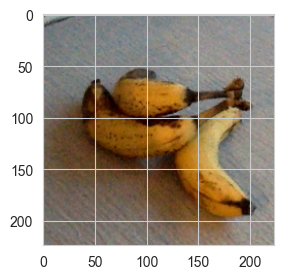

In [5]:
imas_0 = os.listdir(os.path.join(path_train, CLASSES[0]))
ima = imas_0[30]

# show and preprocess image
path_0 = os.path.join(path_train, CLASSES[0])
banana_ima = show_preprocess_image(
    os.path.join(path_0, ima)
)

# making a prediction on the image we just visualized from the raw model
image_class_prediction(
    pretrained_model,
    banana_ima
)

# We can see that the model detects bananas with ease

19-37-21-327785.png


,image_class,probability
0,cleaver,0.376035
1,holster,0.149951
2,loudspeaker,0.146502
3,wallet,0.032433
4,modem,0.028043


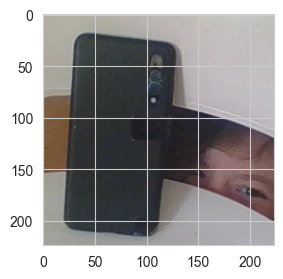

In [6]:
class_ =  CLASSES[1]
imas_ = os.listdir(os.path.join(path_train, class_))
ima_path = imas_[70]
print(ima_path)

# show and preprocess image
path_ = os.path.join(path_train, class_)
ima = show_preprocess_image(
    os.path.join(path_, ima_path)
)

# making a prediction 
image_class_prediction(
    pretrained_model,
    ima
)
# With phones it doesn't do such a good job 
# + iphones are classified as ipods

19-32-15-835977.png


,image_class,probability
0,whistle,0.314410
1,chain,0.219429
2,hook,0.050403
3,knot,0.031928
4,can_opener,0.017996


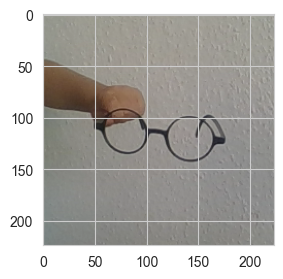

In [7]:
class_ =  CLASSES[2]
imas_ = os.listdir(os.path.join(path_train, class_))
ima_path = imas_[80]
print(ima_path)

# show and preprocess image
path_ = os.path.join(path_train, class_)
ima = show_preprocess_image(
    os.path.join(path_, ima_path)
)

# making a prediction 
image_class_prediction(
    pretrained_model,
    ima
)

# Sunglasses are usually well classified but 
# normal glasses are easely mistaken as hooks

08-00-54-965624.png


,image_class,probability
0,coffee_mug,0.360222
1,thimble,0.186065
2,puffer,0.052099
3,ice_lolly,0.029031
4,saltshaker,0.021841


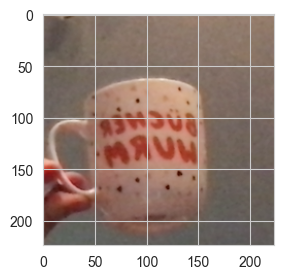

In [8]:
class_ =  CLASSES[3]
imas_ = os.listdir(os.path.join(path_train, class_))
ima_path = imas_[56]
print(ima_path)

# show and preprocess image
path_ = os.path.join(path_train, class_)
ima = show_preprocess_image(
    os.path.join(path_, ima_path)
)

# making a prediction 
image_class_prediction(
    pretrained_model,
    ima
)

# Cups are usually classified pretty well but sometimes 
# the net goes to far and detects them as coffee

In [9]:
# instantiate image data generator
data_gen = image.ImageDataGenerator(
    # preprocessing function for all images
    preprocessing_function=preprocess_input
)

# generate batches of x and y arrays from directory
train_data_gen = data_gen.flow_from_directory(
        directory='./data/train',
        class_mode="categorical",
        classes=CLASSES,
        batch_size=400,
        target_size=(224,224)
)

Found 400 images belonging to 4 classes.


In [10]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((400, 224, 224, 3), (400, 4))

### Build a model

In [11]:
# define base model

BASE_MODEL = MobileNetV2(
    weights='imagenet', 
    alpha=1.0,          # controls number of overall weights
    include_top=False,  # removal of final dense layers
    pooling='avg',      # average pooling to last convolutional layer's ouput
    input_shape=(224,224,3) # ignored if input tensor is provided
)

# freeze base model
BASE_MODEL.trainable = False

# base model summary
BASE_MODEL.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [12]:
def HyperModel(hyperparameters):
    '''
    creates a hypermodel by stacking dense layers on top of base model. 
    Two hyperparameters to be tuned: 
    1. number of neurons in the first dense layer,
    2. initial learning rate of the optimizer
    Args:
    hyperparameters - Keras tuner object
    '''
    # initialize the Sequential API to stack the layers
    model = keras.Sequential()
    
    # convolutional base 
    model.add(BASE_MODEL)
    
    # number of neurons in first dense layer
    hp_units = hyperparameters.Choice(
        'units', 
        values=[320,160,80]
    )
    # first dense layer
    model.add(
        keras.layers.Dense(
            units=hp_units, 
            activation='relu'
        )
    )
    # dropout 
    model.add(
        keras.layers.Dropout(
            rate=0.5
        )
    )
    # output layer with softmax activation function
    model.add(
        keras.layers.Dense(
            len(CLASSES),
            activation='softmax'
        )
    )
    # learning rate for the optimizer
    hp_learning_rate = hyperparameters.Choice(
        'learning_rate', 
        values=[1e-2, 1e-3, 1e-4]
    )
    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp_learning_rate
        ),
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy]
    )

    return model


In [13]:
# instantiate hyperband

tuner = kt.GridSearch(
    hypermodel=HyperModel,
    objective='val_categorical_accuracy'
)

# hypertuning settings summary
tuner.search_space_summary() 

# early stopping
stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10
)

INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 2
units (Choice)
{'default': 320, 'conditions': [], 'values': [320, 160, 80], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [14]:
tuner.search(
    xtrain, 
    ytrain,
    epochs=25,
    validation_split=0.2,
    callbacks=[stop_early]
)

# best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

INFO:tensorflow:Oracle triggered exit


In [15]:
best_hp.get('units')

160

In [16]:
best_hp.get('learning_rate')

0.01

In [17]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 160)               204960    
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 644       
                                                                 
Total params: 2,463,588
Trainable params: 205,604
Non-trainable params: 2,257,984
_________________________________________________________________


#### Train the model

In [18]:
h_model.fit(
    xtrain,
    ytrain,
    epochs=100,
    batch_size=20,
    callbacks=[stop_early],
    validation_split=0.2
)

Epoch 1/100
16/16 [==============================] - 20s 1s/step - loss: 1.7594 - categorical_accuracy: 0.7219 - val_loss: 0.3215 - val_categorical_accuracy: 0.9625
Epoch 2/100
16/16 [==============================] - 15s 931ms/step - loss: 0.4063 - categorical_accuracy: 0.9375 - val_loss: 0.2813 - val_categorical_accuracy: 0.9500
Epoch 3/100
16/16 [==============================] - 14s 896ms/step - loss: 0.2284 - categorical_accuracy: 0.9563 - val_loss: 0.0513 - val_categorical_accuracy: 0.9625
Epoch 4/100
16/16 [==============================] - 14s 871ms/step - loss: 0.4284 - categorical_accuracy: 0.9469 - val_loss: 0.0555 - val_categorical_accuracy: 0.9875
Epoch 5/100
16/16 [==============================] - 14s 883ms/step - loss: 0.1675 - categorical_accuracy: 0.9750 - val_loss: 0.1229 - val_categorical_accuracy: 0.9750
Epoch 6/100
16/16 [==============================] - 14s 906ms/step - loss: 0.0370 - categorical_accuracy: 0.9844 - val_loss: 0.3067 - val_categorical_accuracy: 0.

In [19]:
# losses in the training history
losses = pd.DataFrame(h_model.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

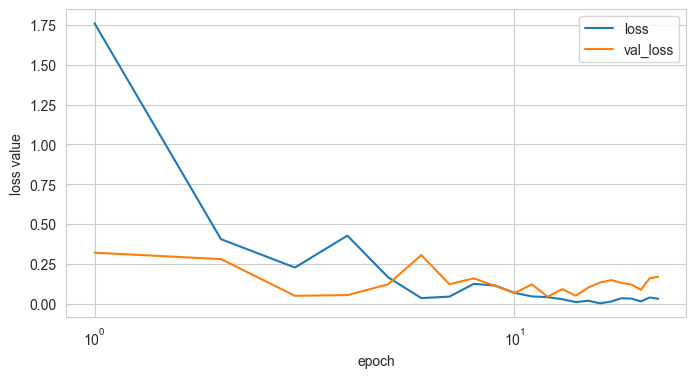

In [20]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,4),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')

plt.xlabel('epoch',fontsize=10)
plt.ylabel('loss value',fontsize=10)
plt.legend(loc=1,fontsize=10);

## Model Testing

In [21]:
# generate batches of x and y arrays from directory
test_data_gen = data_gen.flow_from_directory(
        directory='./data/test',
        class_mode="categorical",
        classes=CLASSES,
        target_size=(224, 224)
)

# load in all images at once
xtest, ytest = next(test_data_gen)
xtest.shape, ytest.shape

Found 40 images belonging to 4 classes.


((32, 224, 224, 3), (32, 4))

In [23]:
# model predictions

test_prediction = transfer_learning_prediction(
    CLASSES,
    h_model,
    xtest,
    ytest
)

test_prediction

,bananas,cellphones,spectacles,cups,class
0,0.000000,0.000000,0.000000,1.000000,cups
1,1.000000,0.000000,0.000000,0.000000,bananas
2,1.000000,0.000000,0.000000,0.000000,bananas
3,0.000000,0.000000,0.000000,1.000000,cups
4,0.000000,1.000000,0.000000,0.000000,cellphones
5,1.000000,0.000000,0.000000,0.000000,bananas
6,0.000000,0.000000,1.000000,0.000000,spectacles
7,0.000000,0.000000,0.000000,1.000000,cups
8,0.000009,0.933026,0.066111,0.000855,cellphones
9,0.000000,0.000000,0.000000,1.000000,cups


In [24]:
accuracy_score(CLASSES, h_model, xtest, ytest)

0.934217

In [25]:
accuracy_score(CLASSES, h_model, xtrain, ytrain)

0.996099

### Visualize some images and their classification

In [34]:
def image_predict(preprocessed_image, model):
    """
    returns class probabilities for a given image,
    based on the model obtained via transfer learning 
    """
    probabilities = model.predict(
        preprocessed_image,
        verbose=0
    )
    probabilities = np.round(probabilities,6)[0]
    class_probabilities = dict(zip(CLASSES,probabilities))
    
    return class_probabilities

{'bananas': 1.0, 'cellphones': 0.0, 'spectacles': 0.0, 'cups': 0.0}

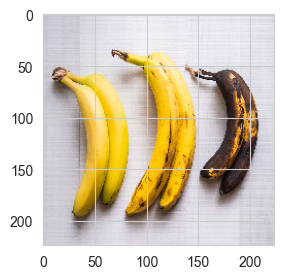

In [35]:
# show and preprocess image
path_test = './data/test'
path_class = os.path.join(path_test, CLASSES[0])
imas_0 = os.listdir(path_class)
ima = imas_0[4]
ima_path = os.path.join(path_class, ima)

test_image = show_preprocess_image(ima_path)

# predict image class
image_predict(test_image, h_model)

{'bananas': 9e-06,
 'cellphones': 0.933026,
 'spectacles': 0.066111,
 'cups': 0.000855}

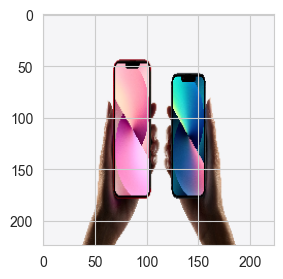

In [36]:
# show and preprocess image
path_test = './data/test'
path_class = os.path.join(path_test, CLASSES[1])
imas_ = os.listdir(path_class)
ima = imas_[4]
ima_path = os.path.join(path_class, ima)

test_image = show_preprocess_image(ima_path)

# predict image class
image_predict(test_image, h_model)

{'bananas': 0.0, 'cellphones': 0.0, 'spectacles': 1.0, 'cups': 0.0}

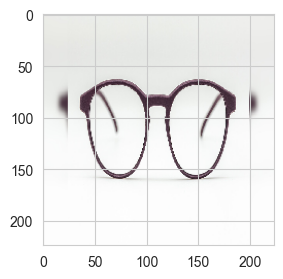

In [37]:
# show and preprocess image
path_test = './data/test'
path_class = os.path.join(path_test, CLASSES[2])
imas_ = os.listdir(path_class)
ima = imas_[4]
ima_path = os.path.join(path_class, ima)

test_image = show_preprocess_image(ima_path)

# predict image class
image_predict(test_image, h_model)

{'bananas': 0.0, 'cellphones': 0.0, 'spectacles': 0.0, 'cups': 1.0}

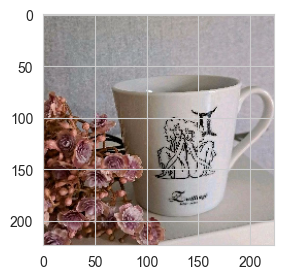

In [38]:
# show and preprocess image
path_test = './data/test'
path_class = os.path.join(path_test, CLASSES[3])
imas_ = os.listdir(path_class)
ima = imas_[4]
ima_path = os.path.join(path_class, ima)

test_image = show_preprocess_image(ima_path)

# predict image class
image_predict(test_image, h_model)